In [20]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import numpy as np
import torch
from torch import nn

SEED = 1337
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True

In [21]:
import  torch.nn.functional as F

SEED = 1337
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True

# -*- coding: utf-8 -*-
class FedNet(nn.Module):
    def __init__(self):
        super(FedNet, self).__init__()

        self.down_1 = nn.Sequential(
            nn.Conv2d(2, 64, 3, 2, 1, bias=False),
            nn.LeakyReLU(),
        )
        self.down_2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
        )
        self.down_3 = nn.Sequential( 
            nn.Conv2d(64, 64, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
        )
        
        self.time = nn.Sequential( 
            nn.Conv2d(192, 64, 1, 1, 0, bias=False),
#             nn.BatchNorm2d(64),
            nn.LeakyReLU(),
        )
        
        self.up_1 = nn.Sequential(
#             nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
        )
        self.up_2 = nn.Sequential(
#             nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
        )
        self.up_3 = nn.Sequential(    
#             nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 2, 3, 1, 1, bias=False),
            
#             nn.Tanh()
        )
        
        self.attr = nn.Sequential(
            nn.Linear(8, 16),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(16, 512),
            nn.Dropout(0.5),
        )
        
        self.init_weight()

    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight.data)


    def forward(self, X, External, batch_size):
        output = torch.FloatTensor(batch_size, 8,16, 16).cuda()
        for i in range(0, 8, 2):
            trend_1 = self.down_1(X[:, 0, i:i+2])
            period_1 = self.down_1(X[:, 1, i:i+2])
            closeness_1 = self.down_1(X[:, 2, i:i+2])

#             if i == 0:
#                 closeness_1 = self.down_1(X[:, 2, i:i+2])
#             else:
#                 closeness_1 = self.down_1(f)
                
            time_1 = self.time(torch.cat([trend_1, period_1, closeness_1], dim=1)) # 8*8

            trend_2 = self.down_2(trend_1)
            period_2 = self.down_2(period_1)
            closeness_2 = self.down_2(closeness_1)
        
            time_2 = self.time(torch.cat([trend_2, period_2, closeness_2], dim=1)) # 4*4
        
            trend_3 = self.down_3(trend_2)
            period_3 = self.down_3(period_2)
            closeness_3 = self.down_3(closeness_2)
         
            time_3 = self.time(torch.cat([trend_3, period_3, closeness_3], dim=1)) # 2*2
        
            f = self.up_1(F.interpolate(time_3, scale_factor=2))
        
            f = self.up_2(F.interpolate((f+time_2), scale_factor=2))
                     
            f = self.up_3(F.interpolate((f+time_1), scale_factor=2))
        
            attr = self.attr(External[:, i//2:i//2+1])
            attr = attr.view(-1, 2, 16, 16)
        
            f = F.tanh(f+attr)
            
            output[:, i: i+2] = f
        return output

In [22]:
SEED = 1337
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True

# -*- coding: utf-8 -*-
import pickle
import math
import time
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from torch import optim
from torch.utils.data import DataLoader

lr = 0.001
batch_size = 32
val_batch_size = 240
test_batch_size = 240

train_epochs = 100

x = open("data/taxi_021616_X_04.pkl", 'rb')
X = pickle.load(x)
x.close()

y = open("data/taxi_021616_Y_04.pkl", 'rb')
Y = pickle.load(y)
y.close()

external = open("data/taxi_021616_External_04.pkl", 'rb')
External = pickle.load(external)
external.close()

train_X = X[:-240]
train_Y = Y[:-240]
train_External = External[:-240]

test_X = X[-240:]
test_Y = Y[-240:]
test_External = External[-240:]

In [23]:
SEED = 1337
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True

x_test_cuda = torch.tensor(test_X, dtype=torch.float32).cuda()
y_test_cuda = torch.tensor(test_Y, dtype=torch.float32).cuda()
external_test_cuda = torch.tensor(test_External, dtype=torch.float32).cuda()

test = torch.utils.data.TensorDataset(x_test_cuda, y_test_cuda, external_test_cuda)

test_loader = torch.utils.data.DataLoader(test, batch_size=test_batch_size, shuffle=False)

train_best = np.zeros([len(train_Y), 8, 16 , 16])
test_best = np.zeros([len(test_Y), 8, 16 , 16])

splits = list(KFold(n_splits=5, shuffle=True, random_state=SEED).split(train_X, train_Y))

for i_fold, (train_idx, valid_idx) in enumerate(splits):
    x_train_fold = torch.tensor(train_X[train_idx], dtype=torch.float32).cuda()
    y_train_fold = torch.tensor(train_Y[train_idx], dtype=torch.float32).cuda()
    external_train_fold = torch.tensor(train_External[train_idx], dtype=torch.float32).cuda()

    x_val_fold = torch.tensor(train_X[valid_idx], dtype=torch.float32).cuda()
    y_val_fold = torch.tensor(train_Y[valid_idx], dtype=torch.float32).cuda()
    external_val_fold = torch.tensor(train_External[valid_idx], dtype=torch.float32).cuda()

    model = FedNet()

    model.cuda()
    
    optimizer = optim.Adam(model.parameters())
#     optimizer = optim.SGD(model.parameters(), lr=0.01)

    criterion = nn.MSELoss()
        
    train = torch.utils.data.TensorDataset(x_train_fold, y_train_fold, external_train_fold)
    valid = torch.utils.data.TensorDataset(x_val_fold, y_val_fold, external_val_fold)
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=val_batch_size, shuffle=False)

    print(f'Fold {i_fold + 1}')
    
    history_loss = float("inf")

    for epoch in range(train_epochs):
        start_time = time.time()
        
        model.train()
        for i, (x_batch, y_batch, e_batch) in enumerate(train_loader, 1):
#             print(e_batch.shape)
            y_pred = model(x_batch, e_batch, x_batch.shape[0])
            loss = criterion(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        model.eval()
        
        valid_preds_fold = np.zeros([len(y_val_fold), 8, 16 , 16])
        
        avg_val_loss = 0.0
        for i, (x_batch, y_batch, e_batch) in enumerate(valid_loader):
            y_pred = model(x_batch, e_batch, x_batch.shape[0]).detach()
            valid_preds_fold[i * val_batch_size:(i+1) * val_batch_size] = y_pred.cpu().numpy() 
            
            avg_val_loss += criterion(y_pred[:, 0:2], y_batch[:, 0:2]) / len(valid_loader)
            
        print(f'epoch_{epoch}: ', avg_val_loss**0.5*3057/2)
        
        if avg_val_loss < history_loss:
            history_loss = avg_val_loss
            torch.save(model, f'best_taxi_tf_04_{i_fold + 1}.pkl')
    
    model = torch.load(f'best_taxi_tf_04_{i_fold + 1}.pkl')
    model.eval()
    
    avg_val_loss = 0.0
    
    valid_preds_fold = np.zeros([len(y_val_fold), 8, 16 , 16])

    for i, (x_batch, y_batch, e_batch) in enumerate(valid_loader):
        y_pred = model(x_batch, e_batch, x_batch.shape[0]).detach()            
        valid_preds_fold[i * val_batch_size:(i+1) * val_batch_size] = y_pred.cpu().numpy() 
        
        avg_val_loss += criterion(y_pred[:, 0:2], y_batch[:, 0:2]) / len(valid_loader)
        
    print(f'val_{i_fold + 1}: ', avg_val_loss**0.5*3057/2)
    
    train_best[valid_idx] = valid_preds_fold
    
    test_preds_fold = np.zeros([len(test_Y), 8, 16, 16])

    for i, (x_batch, y_batch, e_batch) in enumerate(test_loader):
        y_pred = model(x_batch, e_batch, x_batch.shape[0]).detach()
        test_preds_fold[i * test_batch_size:(i+1) * test_batch_size] = y_pred.cpu().numpy()           
    
    print(mean_squared_error(test_preds_fold[:, 0:2].reshape(-1, 1), test_Y[:, 0:2].reshape(-1, 1))**0.5*3057/2)
    
    test_best += test_preds_fold / 5

Fold 1


/home/xiaosen/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch_0:  tensor(76.1484, device='cuda:0')


/home/xiaosen/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type FedNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch_1:  tensor(52.3368, device='cuda:0')
epoch_2:  tensor(44.2129, device='cuda:0')
epoch_3:  tensor(41.0058, device='cuda:0')
epoch_4:  tensor(36.1051, device='cuda:0')
epoch_5:  tensor(34.6634, device='cuda:0')
epoch_6:  tensor(32.3176, device='cuda:0')
epoch_7:  tensor(33.7017, device='cuda:0')
epoch_8:  tensor(32.0932, device='cuda:0')
epoch_9:  tensor(28.1169, device='cuda:0')
epoch_10:  tensor(28.7246, device='cuda:0')
epoch_11:  tensor(26.8019, device='cuda:0')
epoch_12:  tensor(25.7896, device='cuda:0')
epoch_13:  tensor(28.1253, device='cuda:0')
epoch_14:  tensor(25.7339, device='cuda:0')
epoch_15:  tensor(25.8587, device='cuda:0')
epoch_16:  tensor(23.9966, device='cuda:0')
epoch_17:  tensor(26.6511, device='cuda:0')
epoch_18:  tensor(23.5819, device='cuda:0')
epoch_19:  tensor(27.3472, device='cuda:0')
epoch_20:  tensor(23.2516, device='cuda:0')
epoch_21:  tensor(24.4153, device='cuda:0')
epoch_22:  tensor(25.0344, device='cuda:0')
epoch_23:  tensor(22.3784, device='cuda:0

epoch_87:  tensor(18.6142, device='cuda:0')
epoch_88:  tensor(18.1198, device='cuda:0')
epoch_89:  tensor(18.4877, device='cuda:0')
epoch_90:  tensor(17.2427, device='cuda:0')
epoch_91:  tensor(19.5884, device='cuda:0')
epoch_92:  tensor(16.5692, device='cuda:0')
epoch_93:  tensor(17.5550, device='cuda:0')
epoch_94:  tensor(17.8574, device='cuda:0')
epoch_95:  tensor(16.6202, device='cuda:0')
epoch_96:  tensor(16.1382, device='cuda:0')
epoch_97:  tensor(16.9529, device='cuda:0')
epoch_98:  tensor(18.4892, device='cuda:0')
epoch_99:  tensor(18.3338, device='cuda:0')
val_2:  tensor(16.1382, device='cuda:0')
23.1387828809076
Fold 3
epoch_0:  tensor(81.0984, device='cuda:0')
epoch_1:  tensor(53.3683, device='cuda:0')
epoch_2:  tensor(43.7667, device='cuda:0')
epoch_3:  tensor(39.7719, device='cuda:0')
epoch_4:  tensor(37.8849, device='cuda:0')
epoch_5:  tensor(35.1050, device='cuda:0')
epoch_6:  tensor(32.0059, device='cuda:0')
epoch_7:  tensor(35.2971, device='cuda:0')
epoch_8:  tensor(30

epoch_71:  tensor(17.8094, device='cuda:0')
epoch_72:  tensor(19.4902, device='cuda:0')
epoch_73:  tensor(18.1439, device='cuda:0')
epoch_74:  tensor(18.2516, device='cuda:0')
epoch_75:  tensor(17.2647, device='cuda:0')
epoch_76:  tensor(18.2276, device='cuda:0')
epoch_77:  tensor(18.4778, device='cuda:0')
epoch_78:  tensor(18.0602, device='cuda:0')
epoch_79:  tensor(17.6946, device='cuda:0')
epoch_80:  tensor(17.2310, device='cuda:0')
epoch_81:  tensor(17.3473, device='cuda:0')
epoch_82:  tensor(17.2627, device='cuda:0')
epoch_83:  tensor(17.4717, device='cuda:0')
epoch_84:  tensor(17.1194, device='cuda:0')
epoch_85:  tensor(17.8775, device='cuda:0')
epoch_86:  tensor(20.0879, device='cuda:0')
epoch_87:  tensor(17.3122, device='cuda:0')
epoch_88:  tensor(17.9760, device='cuda:0')
epoch_89:  tensor(16.9745, device='cuda:0')
epoch_90:  tensor(18.0001, device='cuda:0')
epoch_91:  tensor(16.9635, device='cuda:0')
epoch_92:  tensor(18.3245, device='cuda:0')
epoch_93:  tensor(17.9198, devic

In [24]:
print(mean_squared_error(train_best.reshape(-1, 1), train_Y.reshape(-1, 1))**0.5*3057/2)

16.159313820696898


In [25]:
print(mean_squared_error(test_best.reshape(-1, 1), test_Y.reshape(-1, 1))**0.5*3057/2)

21.853315864339955


In [26]:
print(mean_squared_error(test_best[:, 0:2].reshape(-1, 1), test_Y[:, 0:2].reshape(-1, 1))**0.5*3057/2)

21.847610521373


In [33]:
import matplotlib.pyplot as plt
i = 12
j = 8

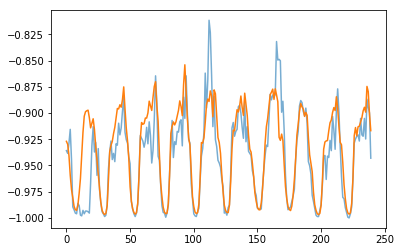

In [34]:
plt.plot(test_Y[:, 0, i, j], alpha=0.6)
plt.plot(test_best[:, 0, i, j])

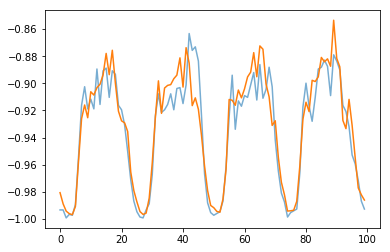

In [35]:
plt.plot(train_Y[0:100, 0, i, j], alpha=0.6)
plt.plot(train_best[0:100, 0, i, j])